# [Advent of Code 2021](https://adventofcode.com/2021)

Starting from day 10, I'll try to follow [Norvig's approach](https://github.com/norvig/pytudes/blob/main/ipynb/Advent-2020.ipynb), with all solutions in a single notebook.

# Helpers

Most of the helpers are taken from Norvig's notebook.

In [1]:
import math
import sys
import re
import itertools
from collections import Counter, defaultdict, deque
from itertools import permutations, combinations, product
from functools import cache, reduce
from dataclasses import dataclass
import operator

# display() is already available, but Pylance is unaware. This import helps.
# https://github.com/microsoft/pylance-release/issues/1598
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy

def first(iterable, default=None):
    "Return first item in `iterable`, or `default`."
    return next(iter(iterable), default)

def last(iterable, default=None):
    "Return last item in `iterable`, or `default`."
    it = default
    for it in iterable: pass
    return it

def quantify(iterable, pred=bool) -> int:
    "Count the number of items in `iterable` for which `pred` is true."
    return sum(1 for item in iterable if pred(item))

def ints(text: str) -> list[int]:
    "Return all integers in `text`."
    return list(map(int, re.findall('-?[0-9]+', text)))

def data(inp: str, parser=str, sep='\n') -> list:
    "Parse input into sections separated by `sep`, and apply `parser` to each."
    sections = inp.rstrip().split(sep)
    return [parser(section) for section in sections]

def do(day, *answers, ex=None):
    "E.g., `do(3)` returns `{1: day3_1(in3), 2: day3_2(in3)}`. Verifies `answers` if given."
    g = globals()
    got = []
    parse = g[f'parse{day}']
    data = f'ex{day}_{ex}' if ex else f'in{day}'
    for part in (1, 2):
        fname = f'day{day}_{part}'
        if fname in g:
            got.append(g[fname](parse(g[data])))
            if len(answers) >= part and answers[part - 1] != Ellipsis:
                assert got[-1] == answers[part - 1], (
                    f'{fname}(parse{day}({data})) got {got[-1]}; expected {answers[part - 1]}')
    return got

cat = ''.join
flatten = itertools.chain.from_iterable

# Day 10: Syntax Scoring

Analyze inputs with unmatched characters.

In [2]:
ex10 = '''[({(<(())[]>[[{[]{<()<>>
[(()[<>])]({[<{<<[]>>(
{([(<{}[<>[]}>{[]{[(<()>
(((({<>}<{<{<>}{[]{[]{}
[[<[([]))<([[{}[[()]]]
[{[{({}]{}}([{[{{{}}([]
{<[[]]>}<{[{[{[]{()[[[]
[<(<(<(<{}))><([]([]()
<{([([[(<>()){}]>(<<{{
<{([{{}}[<[[[<>{}]]]>[]]'''
in10 = open('day10.txt').read()

In [3]:
def parse10(I): return data(I)
#parse10(ex10)

In [4]:
def match_errors(line):
    open, close = '([{<', ')]}>'
    s = []
    while line:
        c, *line = line
        if c in close:
            if s.pop() != open[close.index(c)]:
                return close.index(c) # unexpected character index ('corrupted' line)
        elif c in open:
            s.append(c)
    return s # unbalanced characters stack ('incomplete' line)

In [5]:
def day10_1(D):
    points = [3, 57, 1197, 25137]
    return sum(points[r] for r in map(match_errors, D) if not isinstance(r, list))
day10_1(parse10(ex10))

26397

In [6]:
day10_1(parse10(in10))

388713

In [7]:
def day10_2(D):
    def score(cs): return reduce(lambda r, c: r * 5 + '([{<'.index(c) + 1, cs, 0)
    scores = sorted(score(reversed(r)) for r in map(match_errors, D) if isinstance(r, list))
    return scores[len(scores) // 2]
day10_2(parse10(ex10))

288957

In [8]:
day10_2(parse10(in10))

3539961434

# Day 11: Dumbo Octopus

The task is to implement the algorithm that looks like [Game of Life], with notable differences:
* The grid is fixed size - 10x10. Game of Life has infinite grid.
* Calculating next step can take multiple iterations, in a [fixed-point][] fashion. In contrast, Game of Life can be implemented with a single iteration.

(See also [my solution][day17-solution] to [Advent of Code 2020, day 17][day17].)

[fixed-point]: https://en.wikipedia.org/wiki/Fixed_point_(mathematics)
[Game of Life]: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
[day17-solution]: https://github.com/shamrin/adventofcode/blob/main/2020/17.py
[day17]: https://adventofcode.com/2020/day/17

## Parsing

In [9]:
ex11 = '''5483143223
2745854711
5264556173
6141336146
6357385478
4167524645
2176841721
6882881134
4846848554
5283751526'''
in11 = open('day11.txt').read()

In [10]:
def parse11(I): return data(I, lambda a: list(map(int, a)))
parse11(ex11)

[[5, 4, 8, 3, 1, 4, 3, 2, 2, 3],
 [2, 7, 4, 5, 8, 5, 4, 7, 1, 1],
 [5, 2, 6, 4, 5, 5, 6, 1, 7, 3],
 [6, 1, 4, 1, 3, 3, 6, 1, 4, 6],
 [6, 3, 5, 7, 3, 8, 5, 4, 7, 8],
 [4, 1, 6, 7, 5, 2, 4, 6, 4, 5],
 [2, 1, 7, 6, 8, 4, 1, 7, 2, 1],
 [6, 8, 8, 2, 8, 8, 1, 1, 3, 4],
 [4, 8, 4, 6, 8, 4, 8, 5, 5, 4],
 [5, 2, 8, 3, 7, 5, 1, 5, 2, 6]]

## Solution core

The core of the solution is `octopus_flashes` function. It generates numbers of octopuses that flashed after each step.

Main data structure is `g` dictionary. It maps octopus *coordinate* to its current *energy value*.

Auxilary data structures:

* `step_flashes` set - coordinates of octopuses that flashed during the current step *so far*
* `flashes` set - coordinates of octopuses that flashed *right now* 
* `adds` dictionary maps *coordinate* to current flash-induced *energy increase*. For example, `adds[1,1]` tells how many octopuses just flashed next to the octopus at `(1,1)`. Uses [`collections.Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) helper.

In [11]:
def octopus_flashes(I, steps):
    g = {(x,y): c for y, r in enumerate(I) for x, c in enumerate(r)}
    for _ in range(steps):
        g = {p: c+1 for p, c in g.items()}
        step_flashes = set()
        while flashes := {p for p, c in g.items() if c > 9}:
            step_flashes |= flashes
            adds = Counter((x+dx, y+dy) for x, y in flashes for dx in (-1,0,1) for dy in (-1,0,1))
            g = {p: 0 if p in step_flashes else c+adds[p] for p, c in g.items()}
        yield len(step_flashes)

## Part 1

In [12]:
def day11_1(D): return sum(octopus_flashes(D, 100))
day11_1(parse11(ex11))

1656

In [13]:
day11_1(parse11(in11))

1608

## Part 2

In [14]:
def day11_2(D): return next(i+1 for i, f in enumerate(octopus_flashes(D, 10**6)) if f == 100)
day11_2(parse11(ex11))

195

In [15]:
day11_2(parse11(in11))

214

# Day 12: Passage Pathing

## Parsing

In [16]:
ex12_1 = '''start-A
start-b
A-c
A-b
b-d
A-end
b-end'''
ex12_2 = '''dc-end
HN-start
start-kj
dc-start
dc-HN
LN-dc
HN-end
kj-sa
kj-HN
kj-dc'''
ex12_3 = '''fs-end
he-DX
fs-he
start-DX
pj-DX
end-zg
zg-sl
zg-pj
pj-he
RW-he
fs-DX
pj-RW
zg-RW
start-pj
he-WI
zg-he
pj-fs
start-RW'''
in12 = open('day12.txt').read()

In [17]:
def parse12(I):
    d = data(I, lambda s: s.split('-'))
    g = defaultdict(list)
    for v1, v2 in d:
        if v1 != 'end' and v2 != 'start':
            g[v1].append(v2)
        if v2 != 'end' and v1 != 'start':
            g[v2].append(v1)
    return g
parse12(ex12_1)

defaultdict(list,
            {'start': ['A', 'b'],
             'A': ['c', 'b', 'end'],
             'c': ['A'],
             'b': ['A', 'd', 'end'],
             'd': ['b']})

## Solution

In [18]:
def day12_1(G):
    def paths(G, start, end, path=[]):
        path = path + [start]
        if start == end: yield path
        for n in G[start]:
            if n not in path or n.isupper():
                yield from paths(G, n, end, path)
    return quantify(paths(G, 'start', 'end'))

In [19]:
def day12_2(G):
    def paths(G, start, end, path=[], twice=False):
        path = path + [start]
        if start == end: yield path
        for n in G[start]:
            if not twice or n not in path or n.isupper():
                yield from paths(G, n, end, path, twice or (not n.isupper() and n in path))
    return quantify(paths(G, 'start', 'end'))

In [20]:
do(12, 10, 36, ex=1)
do(12, 19, 103, ex=2)
do(12, 226, 3509, ex=3)
do(12, 4186, 92111)

[4186, 92111]

I found it not worth it to combine the parts together. I think they are quite readabable as they are.

# Day 13: Transparent Origami

## Parsing

In [21]:
ex13_1 = '''6,10
0,14
9,10
0,3
10,4
4,11
6,0
6,12
4,1
0,13
10,12
3,4
3,0
8,4
1,10
2,14
8,10
9,0

fold along y=7
fold along x=5'''
in13 = open('day13.txt').read()

In [22]:
def parse13(I):
    D = data(I, lambda s: s.split('\n'), '\n\n')
    D = (
        [tuple(map(int,s.split(','))) for s in D[0]],
        [s.rpartition(' ')[2].split('=') for s in D[1]],
    )
    return D[0], [(xy, int(f)) for xy, f in D[1]]
parse13(ex13_1)

([(6, 10),
  (0, 14),
  (9, 10),
  (0, 3),
  (10, 4),
  (4, 11),
  (6, 0),
  (6, 12),
  (4, 1),
  (0, 13),
  (10, 12),
  (3, 4),
  (3, 0),
  (8, 4),
  (1, 10),
  (2, 14),
  (8, 10),
  (9, 0)],
 [('y', 7), ('x', 5)])

## Solution

The core of the algorithm is folding one side along horizontal or vertical axis.

First we come with the formula for folding over $x=f$ axis. Folding is the same as *mirroring* all $x > f$ points. To mirror, we first move points to the left, making $x=f$ the new $x=0$ axis:

$x - f$

After the above, mirroring is a simple negation:

$-(x - f)$

Lastly, we undo the initial move, to keep the upcoming $f$ values valid: 

$-(x - f) + f$

**Formula for $x$ folding**, after simplifying the above ($\forall$ means *for all*):

$\forall x > f: x \leftarrow 2 f - x$

**Formula for $y$ folding** is the same:

$\forall y > f: y \leftarrow 2 f - y$

In [23]:
def origami_picture(d):
    return '\n'.join(
        cat('#' if (x,y) in d else '.' for x in range(max(x for x,_ in d) + 1))
        for y in range(max(y for _,y in d) + 1)
    )

def origami_folds(dots, folds):
    def fold(c, f): return 2*f - c if c > f else c
    def foldxy(x, y, xy, f): return fold(x, f) if xy == 'x' else x, fold(y, f) if xy == 'y' else y
    return (dots := {foldxy(x, y, xy, f) for x, y in dots} for xy, f in folds)

def day13_1(D): return len(first(origami_folds(*D)))
def day13_2(D): print(origami_picture(last(origami_folds(*D))))
do(13, 17, ex=1)

#####
#...#
#...#
#...#
#####


[17, None]

In [24]:
do(13, 735)

#..#.####.###..####.#..#..##..#..#.####
#..#.#....#..#....#.#.#..#..#.#..#....#
#..#.###..#..#...#..##...#..#.#..#...#.
#..#.#....###...#...#.#..####.#..#..#..
#..#.#....#.#..#....#.#..#..#.#..#.#...
.##..#....#..#.####.#..#.#..#..##..####


[735, None]

## Alternative solution

Alternative `origami_folds` implementation, possibly easier to quickly type:

1. transform all points to make fold line the new $x=0$ axis: $$x \leftarrow x-f$$
2. mirror all $x>0$ points: $$x \leftarrow -x$$
3. transform all points back: $$x \leftarrow x+f$$

Repeat for $y$.

In [25]:
def origami_folds(d, folds):
    for xy, f in folds:
        if xy == 'x':
            d = {(x - f, y) for x,y in d}
            d = {(-x if x > 0 else x, y) for x,y in d}
            d = {(x + f, y) for x,y in d}
        else:
            d = {(x, y - f) for x,y in d}
            d = {(x, -y if y > 0 else y) for x,y in d}
            d = {(x, y + f) for x,y in d}
        yield d

## OCR

Let's try OCR! Powered by [Pillow](https://pillow.readthedocs.io/), [Tesseract](https://tesseract-ocr.github.io/) and [Python-tesseract](https://github.com/madmaze/pytesseract).

'UFRZKAUZ'

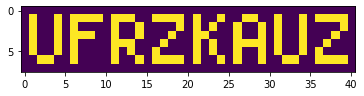

In [26]:

def origami_ocr(d):
    import pytesseract
    import matplotlib.image
    w, h = max(x for x,_ in d) + 1, max(y for _,y in d) + 1
    data = bytes(255 if (x,y) in d else 0 for y in range(-1, h+1) for x in range(-1, w+1))
    W, H = w+2, h+2
    im = Image.frombuffer('L', (W, H), data)
    plt.imshow(matplotlib.image.pil_to_array(im)) # without mpl: display(im.resize((W*4, H*4), Image.NEAREST))
    return pytesseract.image_to_string(im, config='--psm 7').strip()

origami_ocr(last(origami_folds(*parse13(in13))))

# Day 14: Extended Polymerization

In [27]:
ex14_1 = '''NNCB

CH -> B
HH -> N
CB -> H
NH -> C
HB -> C
HC -> B
HN -> C
NN -> C
BH -> H
NC -> B
NB -> B
BN -> B
BB -> N
BC -> B
CC -> N
CN -> C'''
in14 = open('day14.txt').read()

In [28]:
def parse14(I):
    t, _, *rs = I.split('\n')
    return t, dict(r.split(' -> ') for r in rs)

def polymerization(steps, t, rules):
    @cache
    def count(a, b, s=steps):
        if s == 0: return Counter(a)
        m = rules[a+b]
        return count(a, m, s-1) + count(m, b, s-1)
    c = sum(map(count, t, t[1:]), Counter(t[-1]))
    return max(c.values()) - min(c.values())

def day14_1(D): return polymerization(10, *D)
def day14_2(D): return polymerization(40, *D)

do(14, 1588, 2188189693529, ex=1)
do(14, 3118, 4332887448171)

[3118, 4332887448171]

# Day 15: Chiton

## Parsing

In [29]:
ex15_1 = '''1163751742
1381373672
2136511328
3694931569
7463417111
1319128137
1359912421
3125421639
1293138521
2311944581'''
in15 = open('day15.txt').read()

In [30]:
def parse15(I): return data(I, lambda a: list(map(int, a)))
parse15(ex15_1)

[[1, 1, 6, 3, 7, 5, 1, 7, 4, 2],
 [1, 3, 8, 1, 3, 7, 3, 6, 7, 2],
 [2, 1, 3, 6, 5, 1, 1, 3, 2, 8],
 [3, 6, 9, 4, 9, 3, 1, 5, 6, 9],
 [7, 4, 6, 3, 4, 1, 7, 1, 1, 1],
 [1, 3, 1, 9, 1, 2, 8, 1, 3, 7],
 [1, 3, 5, 9, 9, 1, 2, 4, 2, 1],
 [3, 1, 2, 5, 4, 2, 1, 6, 3, 9],
 [1, 2, 9, 3, 1, 3, 8, 5, 2, 1],
 [2, 3, 1, 1, 9, 4, 4, 5, 8, 1]]

## Solution

In [31]:
from typing import Any, TypeVar

T = TypeVar('T')
Graph = dict[T, list[tuple[T, int]]]
ChitonGraph = Graph[tuple[int, int]]

def chiton_graph(D, times) -> tuple[int, ChitonGraph]:
    def clamp(n): return (n - 1) % 9 + 1
    N = len(D[0])
    risk = {
        (x+N*i,y+N*j): clamp(w+i+j)
        for i in range(times) for j in range(times)
        for (y, r) in enumerate(D) for x, w in enumerate(r)
    }

    g: ChitonGraph = defaultdict(list)
    for x, y in risk:
        g[(x, y)].extend(
            ((x+dx, y+dy), risk[x+dx, y+dy])
            for dx, dy in product((-1,0,1), (-1,0,1))
            if abs(dx) != abs(dy) and (x+dx, y+dy) in risk
        )

    return N*times, dict(g)

def shortest_path(g: Graph[T], s: T, t: T) -> tuple[int, list[T]]:
    """Find shortest path from `s` to `t` in graph `g`, using Dijstra algorithm.

    Return shortest path length and the path itself.
    """

    # Inspired by https://stackoverflow.com/a/58833232

    import heapq
    q: list[tuple[int, T]] = [(0, s)]
    dist: dict[T, int] = defaultdict(lambda: sys.maxsize, {s: 0})
    parents = {}
    while q:
        d, u = heapq.heappop(q)
        for v, w in g[u]:
            new_d = d + w
            if new_d < dist[v]:
                dist[v] = new_d
                parents[v] = u
                heapq.heappush(q, (new_d, v))

    path = [t]
    while path[-1] != s:
        path.append(parents[path[-1]])

    return dist[t], path[::-1]

def day15_1(D):
    N, g = chiton_graph(D, 1)
    return shortest_path(g, (0,0), (N-1,N-1))[0]

def day15_2(D):
    N, g = chiton_graph(D, 5)
    return shortest_path(g, (0,0), (N-1,N-1))[0]

do(15, 40, 315, ex=1)
do(15, 415, 2864)

[415, 2864]

## Plot path

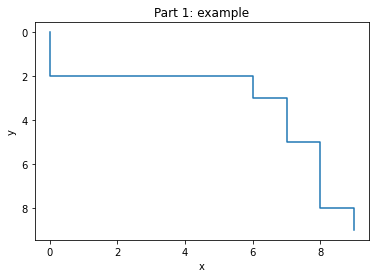

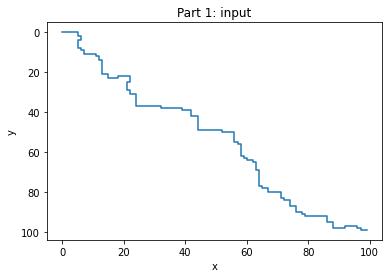

In [32]:
def chiton_plot(I, title):
    N, g = chiton_graph(parse15(I), 1)
    _, path = shortest_path(g, (0,0), (N-1,N-1))

    plt.figure()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.plot(*numpy.array(path).T)

# uncomment to enable interactive plot viewer
# %matplotlib widget
chiton_plot(ex15_1, 'Part 1: example')
chiton_plot(in15, 'Part 1: input')

# Day 16: Packet Decoder

In [33]:
@dataclass
class Packet:
    version: int
    type_id: int
    packets: list['Packet']
    number: int

@dataclass
class PacketReader:
    bits: str
    pos: int = 0
    def read(self, n):
        return int(self.read_raw(n), 2)
    def read_raw(self, n):
        s = self.bits[self.pos:self.pos+n]
        self.pos += n
        return s

def packet_parse(r: PacketReader) -> Packet:
    version, type_id = r.read(3), r.read(3)

    # literal
    if type_id == 4:
        number, cont = '', 1
        while cont:
            cont = r.read(1)
            number += r.read_raw(4)
        return Packet(version, type_id, [], int(number, 2))

    # operator
    length_type_id = r.read(1)
    if length_type_id == 1:
        packets = [packet_parse(r) for _ in range(r.read(11))]
    else:
        length = r.read(15)
        start = r.pos
        packets = []
        while r.pos - start < length:
            packets.append(packet_parse(r))
    return Packet(version, type_id, packets, 0)

def day16_1(bits: str):
    def sumver(p: Packet):
        return p.version + sum(map(sumver, p.packets))
    return sumver(packet_parse(PacketReader(bits)))

def day16_2(bits: str):
    def calculate(p: Packet) -> int:
        return {
            0: sum,
            1: math.prod,
            2: min,
            3: max,
            4: lambda _: p.number,
            5: lambda args: operator.gt(*args),
            6: lambda args: operator.lt(*args),
            7: lambda args: operator.eq(*args),
        }[p.type_id](map(calculate, p.packets))
    return calculate(packet_parse(PacketReader(bits)))

def parse16(I): return cat(bin(byte)[2:].rjust(8, '0') for byte in bytes.fromhex(I))

# part 1 examples
ex16_1 = '8A004A801A8002F478'
ex16_2 = '620080001611562C8802118E34'
ex16_3 = 'C0015000016115A2E0802F182340'
ex16_4 = 'A0016C880162017C3686B18A3D4780'
do(16, 16, ex=1)
do(16, 12, ex=2)
do(16, 23, ex=3)
do(16, 31, ex=4)

# part 2 examples
ex16_5 = 'C200B40A82'
ex16_6 = '04005AC33890'
ex16_7 = '880086C3E88112'
ex16_8 = 'CE00C43D881120'
ex16_9 = 'D8005AC2A8F0'
ex16_10 = 'F600BC2D8F'
ex16_11 = '9C005AC2F8F0'
ex16_12 = '9C0141080250320F1802104A08'
do(16, ..., 3, ex=5)
do(16, ..., 54, ex=6)
do(16, ..., 7, ex=7)
do(16, ..., 9, ex=8)
do(16, ..., 1, ex=9)
do(16, ..., 0, ex=10)
do(16, ..., 0, ex=11)
do(16, ..., 1, ex=12)

in16 = open('day16.txt').read()
do(16, 993, 144595909277)

[993, 144595909277]

# Day 17: Trick Shot

## Solution

In [34]:
ex17_1 = '''target area: x=20..30, y=-10..-5'''
in17 = open('day17.txt').read()
def parse17(I): return ints(I)

Point = tuple[int, int]

def trick_shot_step(x, y, vx, vy):
    vxsign = -1 if vx < 0 else 1
    return x + vx, y + vy, vxsign * (abs(vx) - 1) if vx != 0 else 0, vy - 1

def trick_shot(vx, vy, x1, x2, y1, y2, x=0, y=0) -> list[Point]:
    points: list[tuple[int, int]] = [(x,y)]
    while 1:
        x, y, vx, vy = trick_shot_step(x, y, vx, vy)
        points.append((x, y))
        if y < y1 or x > x2:
            break
    return points

def trick_shots(D) -> set[tuple[int, Point]]:
    x1, x2, y1, y2 = D
    solutions = set()
    for vx0 in range(200):
        for vy0 in range(-200, 200):
            points = trick_shot(vx0, vy0, x1, x2, y1, y2)
            px, py = points[-2]
            if y1 <= py <= y2 and x1 <= px <= x2:
                solutions.add((max(y for _, y in points), (vx0, vy0)))
    return solutions

def day17_1(D): return max(maxy for maxy, _ in trick_shots(D))
def day17_2(D): return len(trick_shots(D))

do(17, 45, 112, ex=1)
do(17, 15400, 5844)

[15400, 5844]

## Plot trajectory

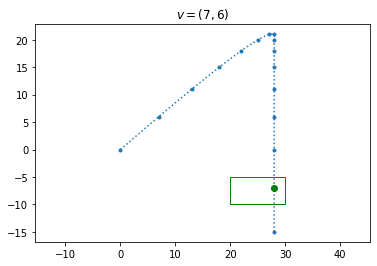

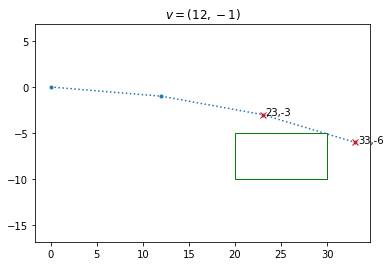

In [35]:
def trick_shot_plot(vx, vy, x1, x2, y1, y2):
    points = trick_shot(vx, vy, x1, x2, y1, y2)

    import matplotlib.patches as patches
    plt.figure()
    rect = patches.Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=1, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)
    plt.axis('equal')
    plt.plot(*numpy.array(points).T, '.:')
    px, py = points[-2]
    plt.title(f'$v=({vx},{vy})$')
    if y1 <= py <= y2 and x1 <= px <= x2:
        plt.plot([px], [py], 'og')
    else:
        for x, y in points[-2:]:
            plt.text(x * (1 + 0.01), y * (1 + 0.01), f'{x},{y}', fontsize=10)
            plt.plot([x], [y], 'xr')

def trick_shot_plots():
    D = parse17(ex17_1)
    _, (vx, vy) = sorted(trick_shots(D))[-7]
    trick_shot_plot(vx, vy, *D)
    trick_shot_plot(12, -1, *D)

# %matplotlib widget
trick_shot_plots()